In [1]:
from notebooks.util.distribution_utils import *

from liquidity.util.utils import compute_returns
from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

## Load market orders raw sample data

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Returns

In [58]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# returns = {stock: data.head(1000000) for stock, data in returns.items()}

### 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [6]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.78
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.00
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.79
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 1.2. Plot returns density functions

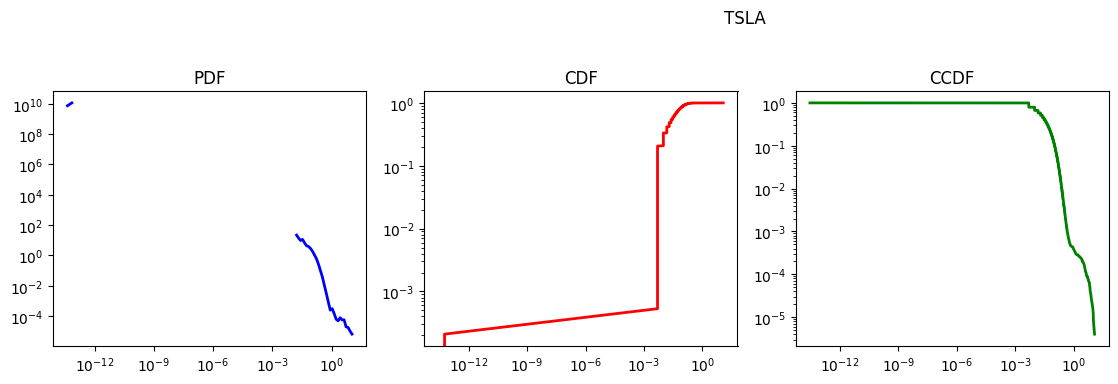

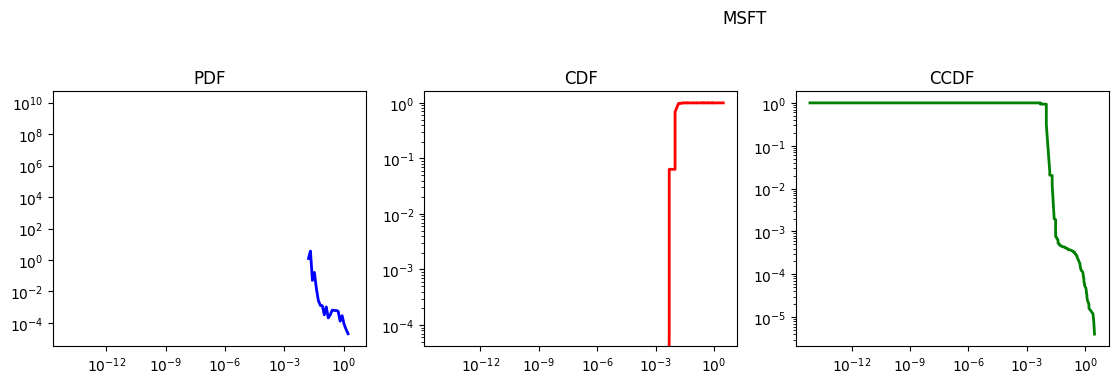

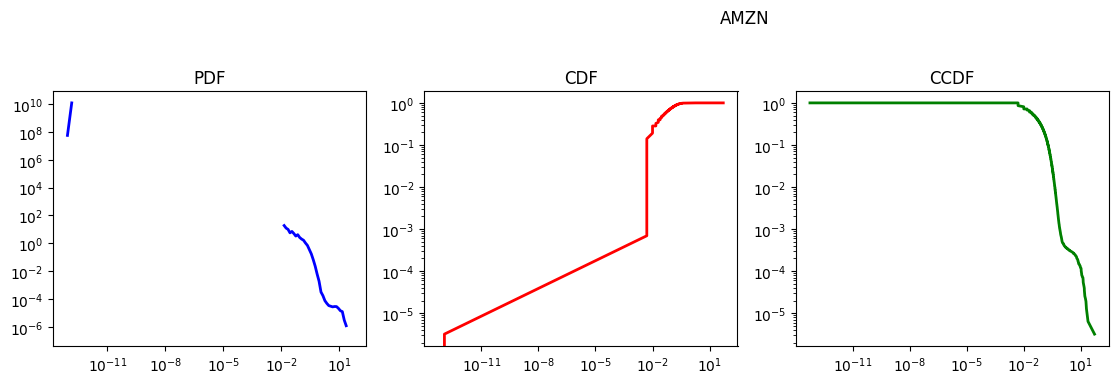

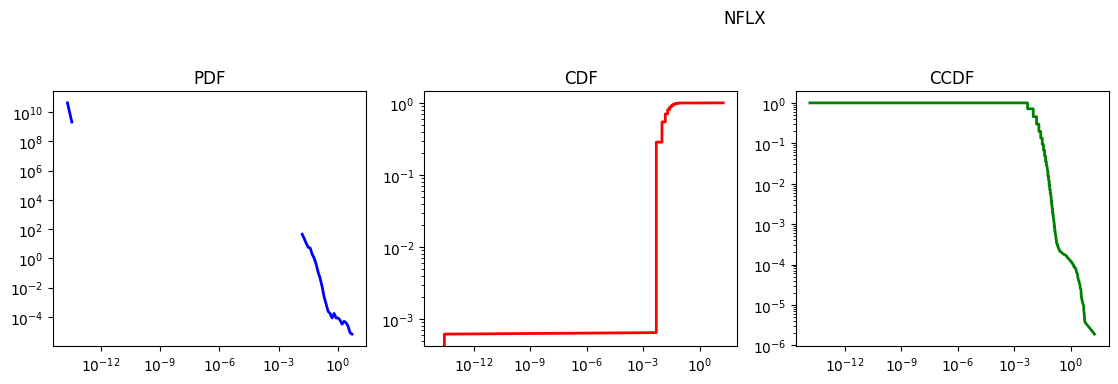

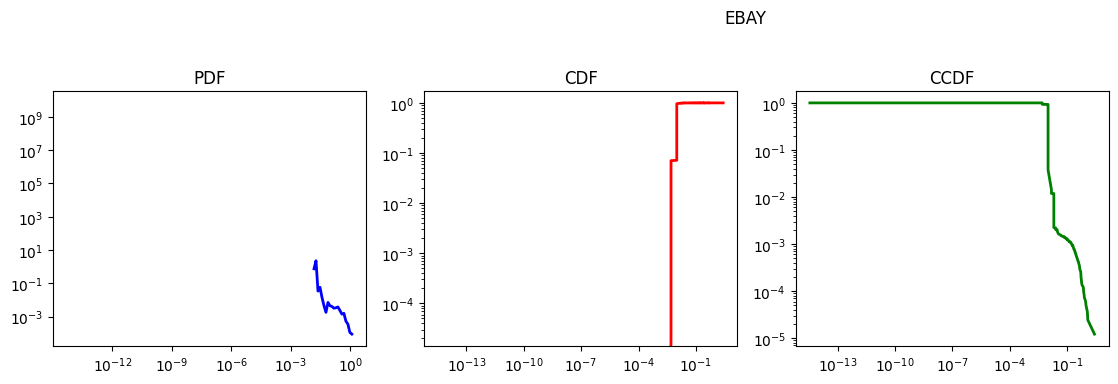

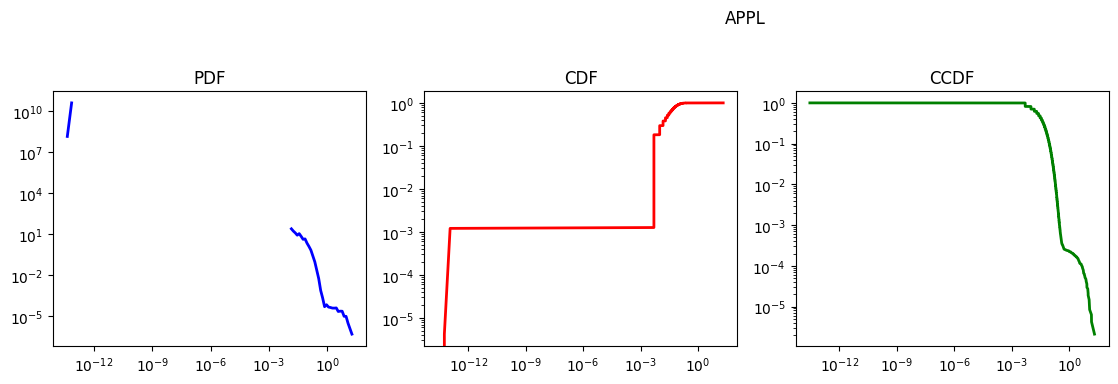

In [59]:
# Plot for each stock
for stock_name, data in returns.items():
    plot_distributions(stock_name, data)

### 1.3. Fit returns power law distribution

In [60]:
# 1. Fit Powerlaw and retrieve fitted object/ results
returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_returns_distributions.pkl')

if not os.path.exists(returns_distributions_data):
    returns_fit_objects = fit_powerlaw(data_dict=returns, filename=returns_distributions_data)
else:
    returns_fit_objects = load_fit_objects(returns_distributions_data)

returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2b832a810>,
 'MSFT': <powerlaw.Fit at 0x2a5ce62d0>,
 'AMZN': <powerlaw.Fit at 0x288fe38d0>,
 'NFLX': <powerlaw.Fit at 0x29c35fe10>,
 'EBAY': <powerlaw.Fit at 0x2a5a2cf10>,
 'APPL': <powerlaw.Fit at 0x2a5b2b8d0>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or ov

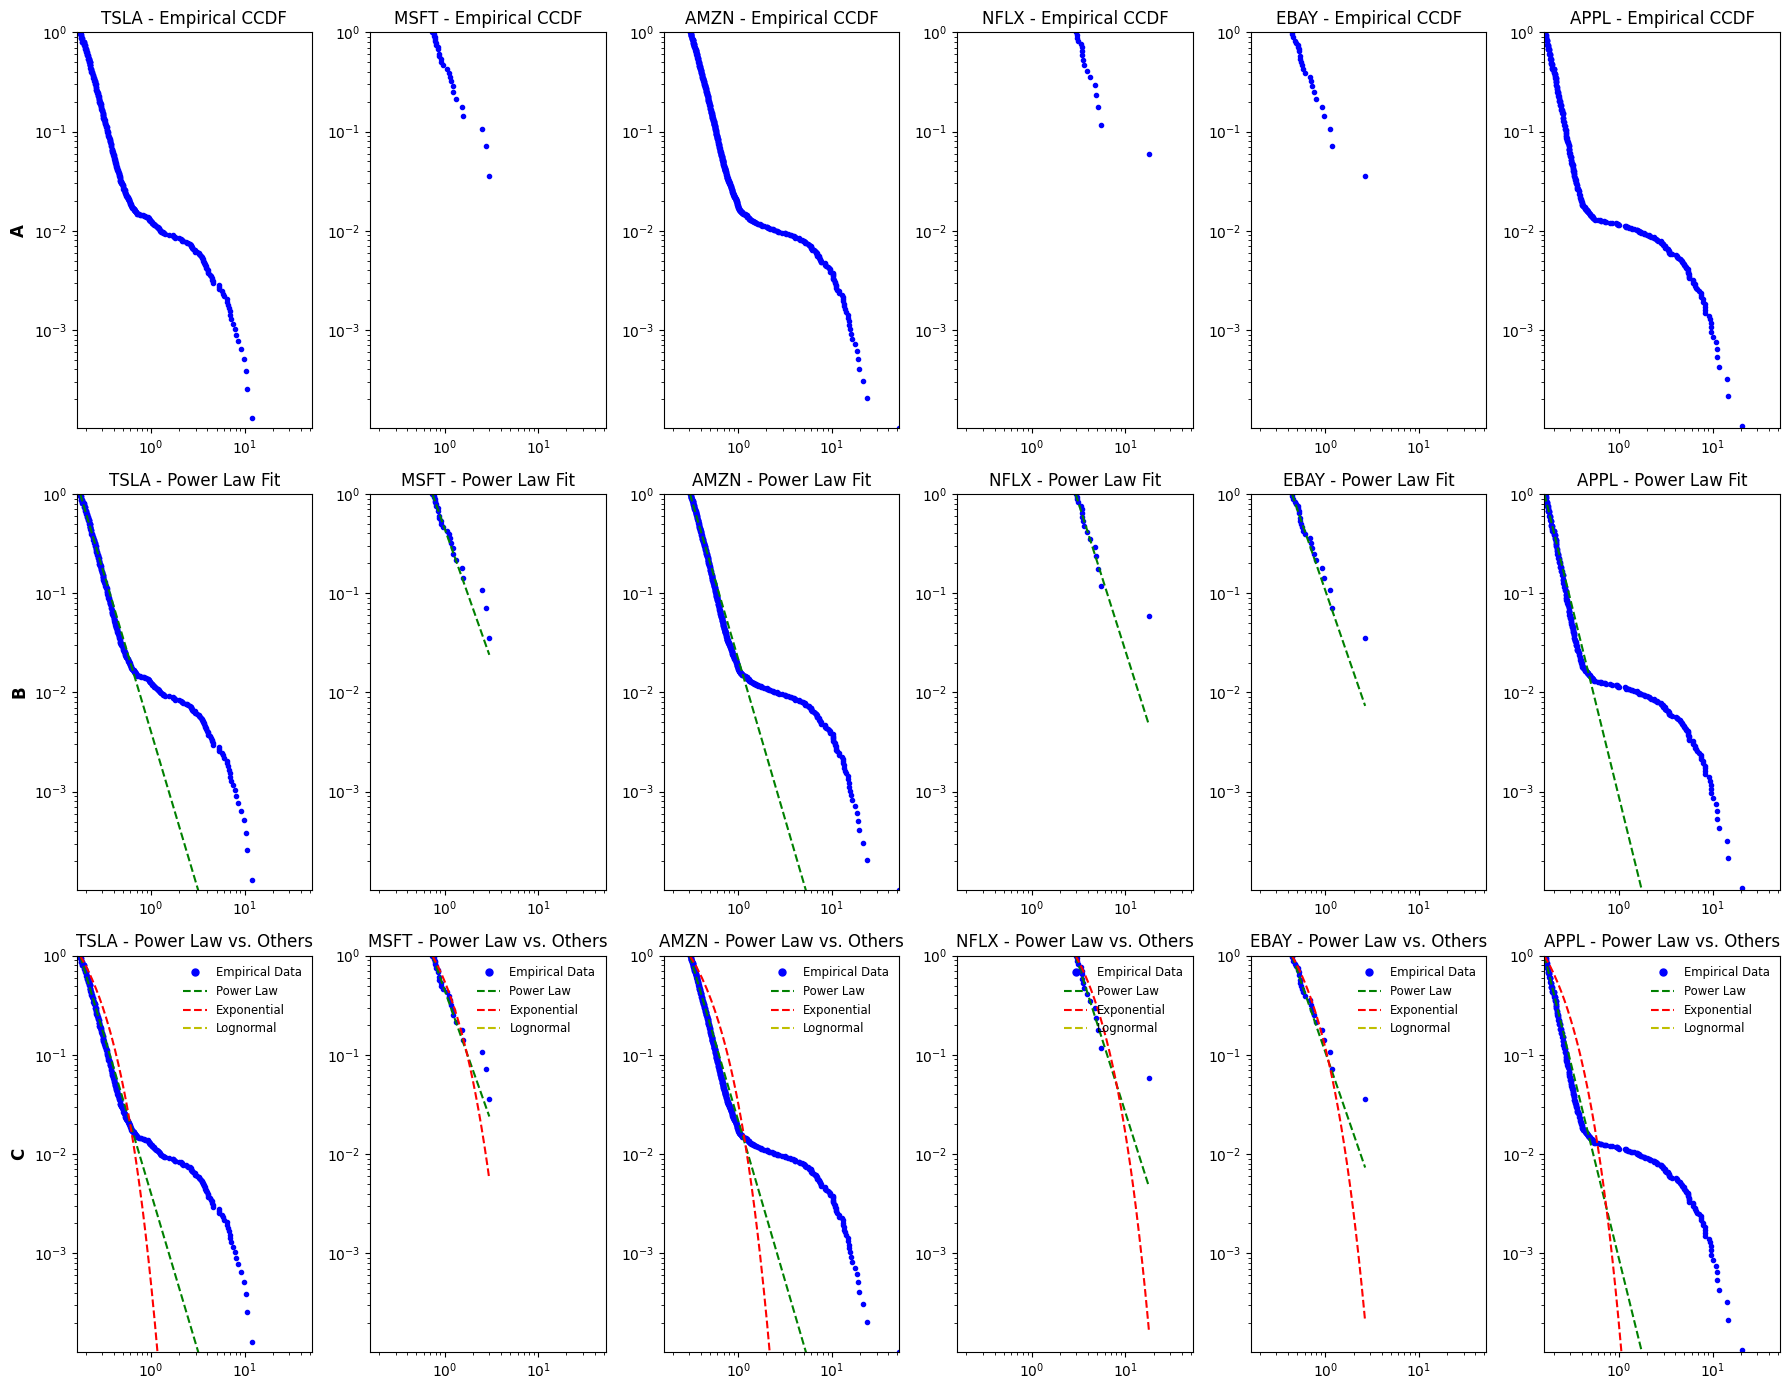

In [61]:
# Plot fitted objects
plot_fit_objects(returns_fit_objects)

#### 1.3.1. Retrieve returns power law fitting results

In [62]:
# Get fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'power_law')
print(returns_power_results)

  Stock Distribution     alpha   xmin  KS Distance
0  TSLA    power_law  4.168750  0.175     0.046951
1  MSFT    power_law  3.666684  0.740     0.078051
2  AMZN    power_law  4.225545  0.305     0.031444
3  NFLX    power_law  3.974212  2.940     0.079087
4  EBAY    power_law  3.732640  0.440     0.081979
5  APPL    power_law  4.838828  0.160     0.055147


In [63]:
# Average Alpha exponents across stocks
min_alpha = returns_power_results['alpha'].min()
max_alpha = returns_power_results['alpha'].max()
avg_alpha = returns_power_results['alpha'].mean()
std_dev_alpha = returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.6666837394081133
Max Alpha: 4.838827838679827
Average Alpha: 4.1011096370660205
std_dev_alpha: 0.42541423300855186


#### 1.3.2. Compare Alternative Distributions

In [64]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
returns_powerlaw_exponential = distribution_compare(returns_fit_objects, 'exponential')
display(returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,9.242861,0.175,4.168750,0.046951,0.203513,9.694856,3.170851e-22
1,MSFT,exponential,2.296925,0.740,3.666684,0.078051,0.170427,1.460363,1.441904e-01
2,AMZN,exponential,4.939013,0.305,4.225545,0.031444,0.231032,10.412466,2.175127e-25
3,NFLX,exponential,0.584483,2.940,3.974212,0.079087,0.199483,1.564487,1.177033e-01
4,EBAY,exponential,3.825132,0.440,3.732640,0.081979,0.179619,1.228318,2.193277e-01
5,APPL,exponential,10.191810,0.160,4.838828,0.055147,0.291514,11.794545,4.164450e-32


## 2. Percentage returns

In [13]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'APPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### 2.1. Stationarity Test

In [14]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.55
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.01
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.59
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.80
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 2.2. Percentage return density functions

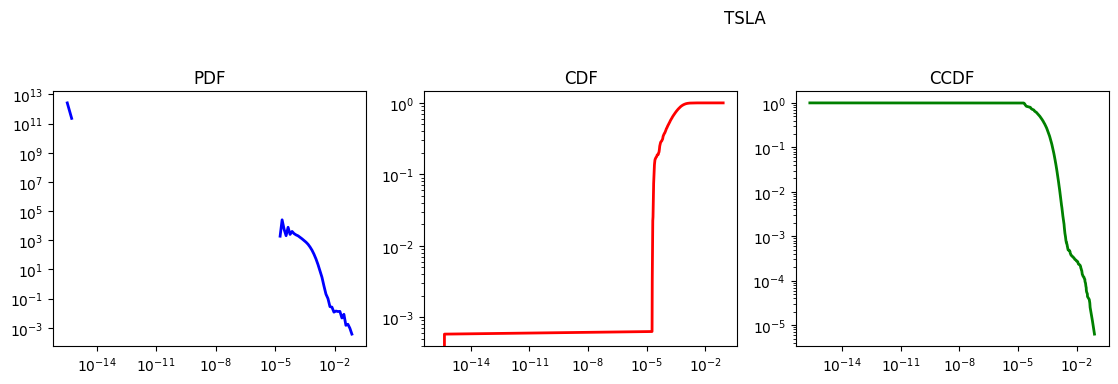

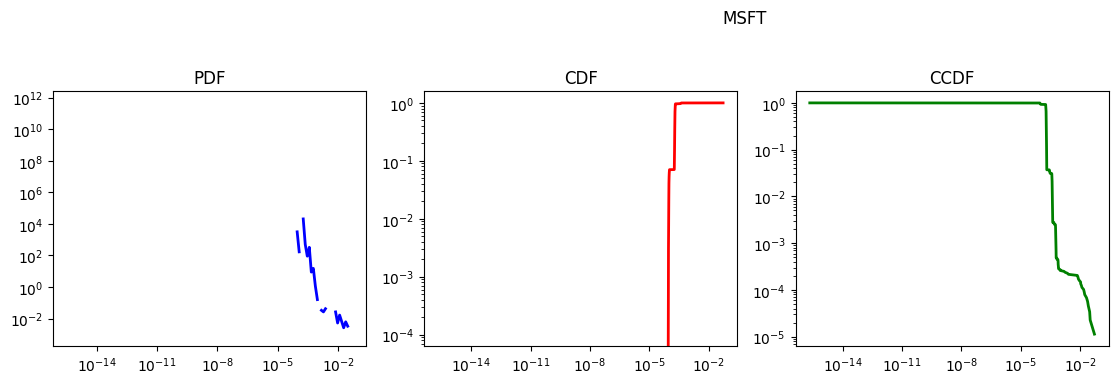

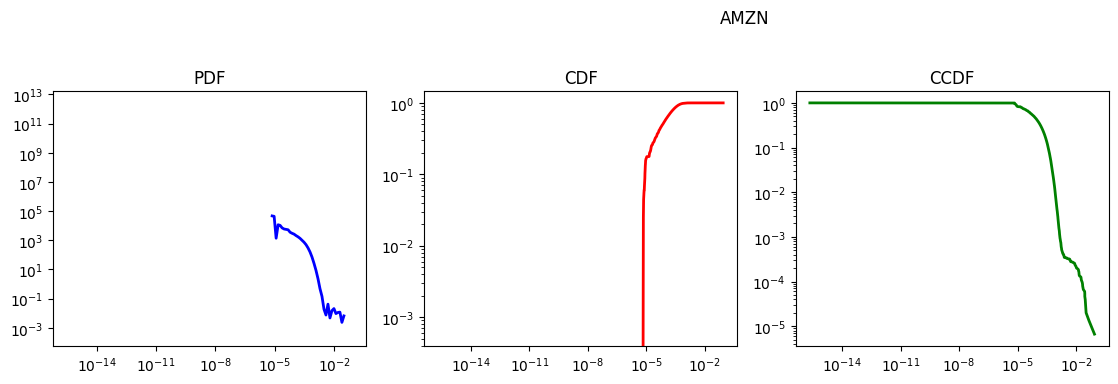

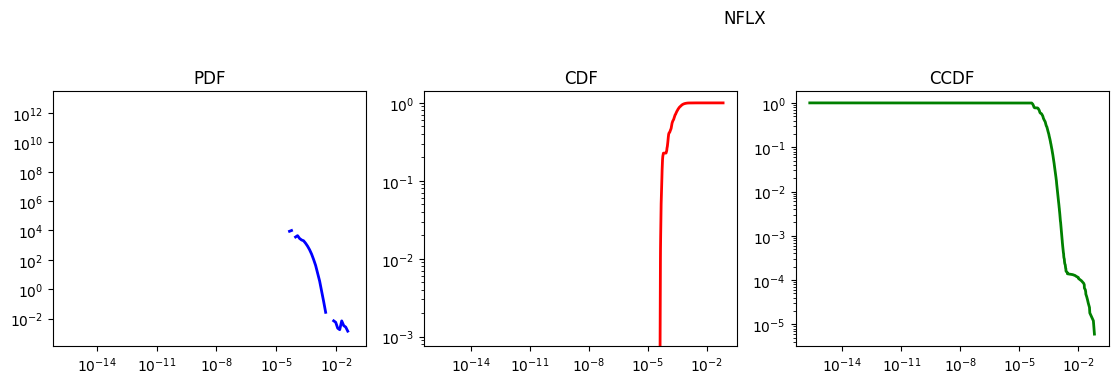

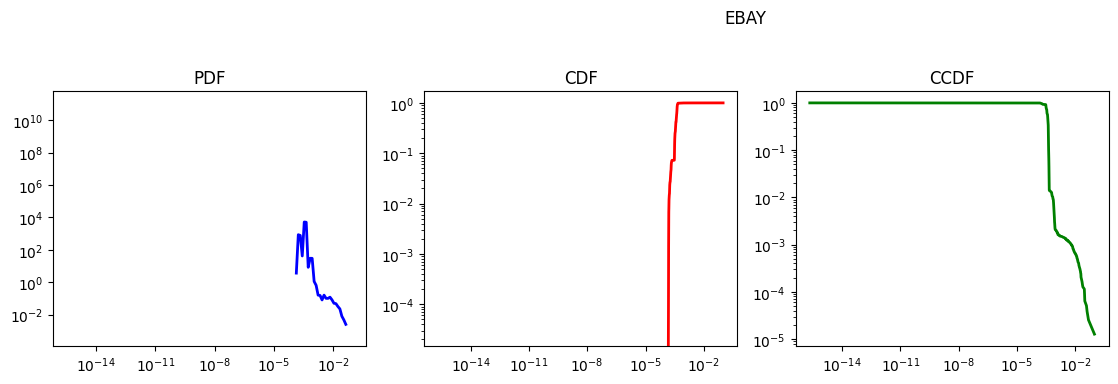

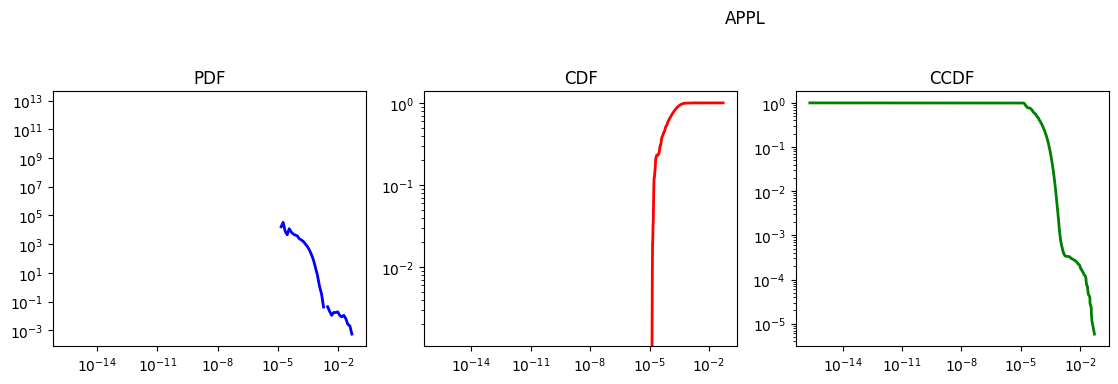

In [15]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in percentage_returns.items():
    plot_distributions(stock_name, data)

### 2.3. Fit power law distribution to percentage returns

In [16]:
# 1. Fit Powerlaw and retrieve fitted object/ results
percentage_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_percentage_returns_distributions.pkl')

if not os.path.exists(percentage_returns_distributions_data):
    percentage_returns_fit_objects = fit_powerlaw(data_dict=percentage_returns, filename=percentage_returns_distributions_data)
else:
    percentage_returns_fit_objects = load_fit_objects(percentage_returns_distributions_data)

percentage_returns_fit_objects

{'TSLA': <powerlaw.Fit at 0x2a5ff6c10>,
 'MSFT': <powerlaw.Fit at 0x28ab58c10>,
 'AMZN': <powerlaw.Fit at 0x2aabff8d0>,
 'NFLX': <powerlaw.Fit at 0x30719d290>,
 'EBAY': <powerlaw.Fit at 0x2a5ef2850>,
 'APPL': <powerlaw.Fit at 0x2a5fb0c50>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or ov

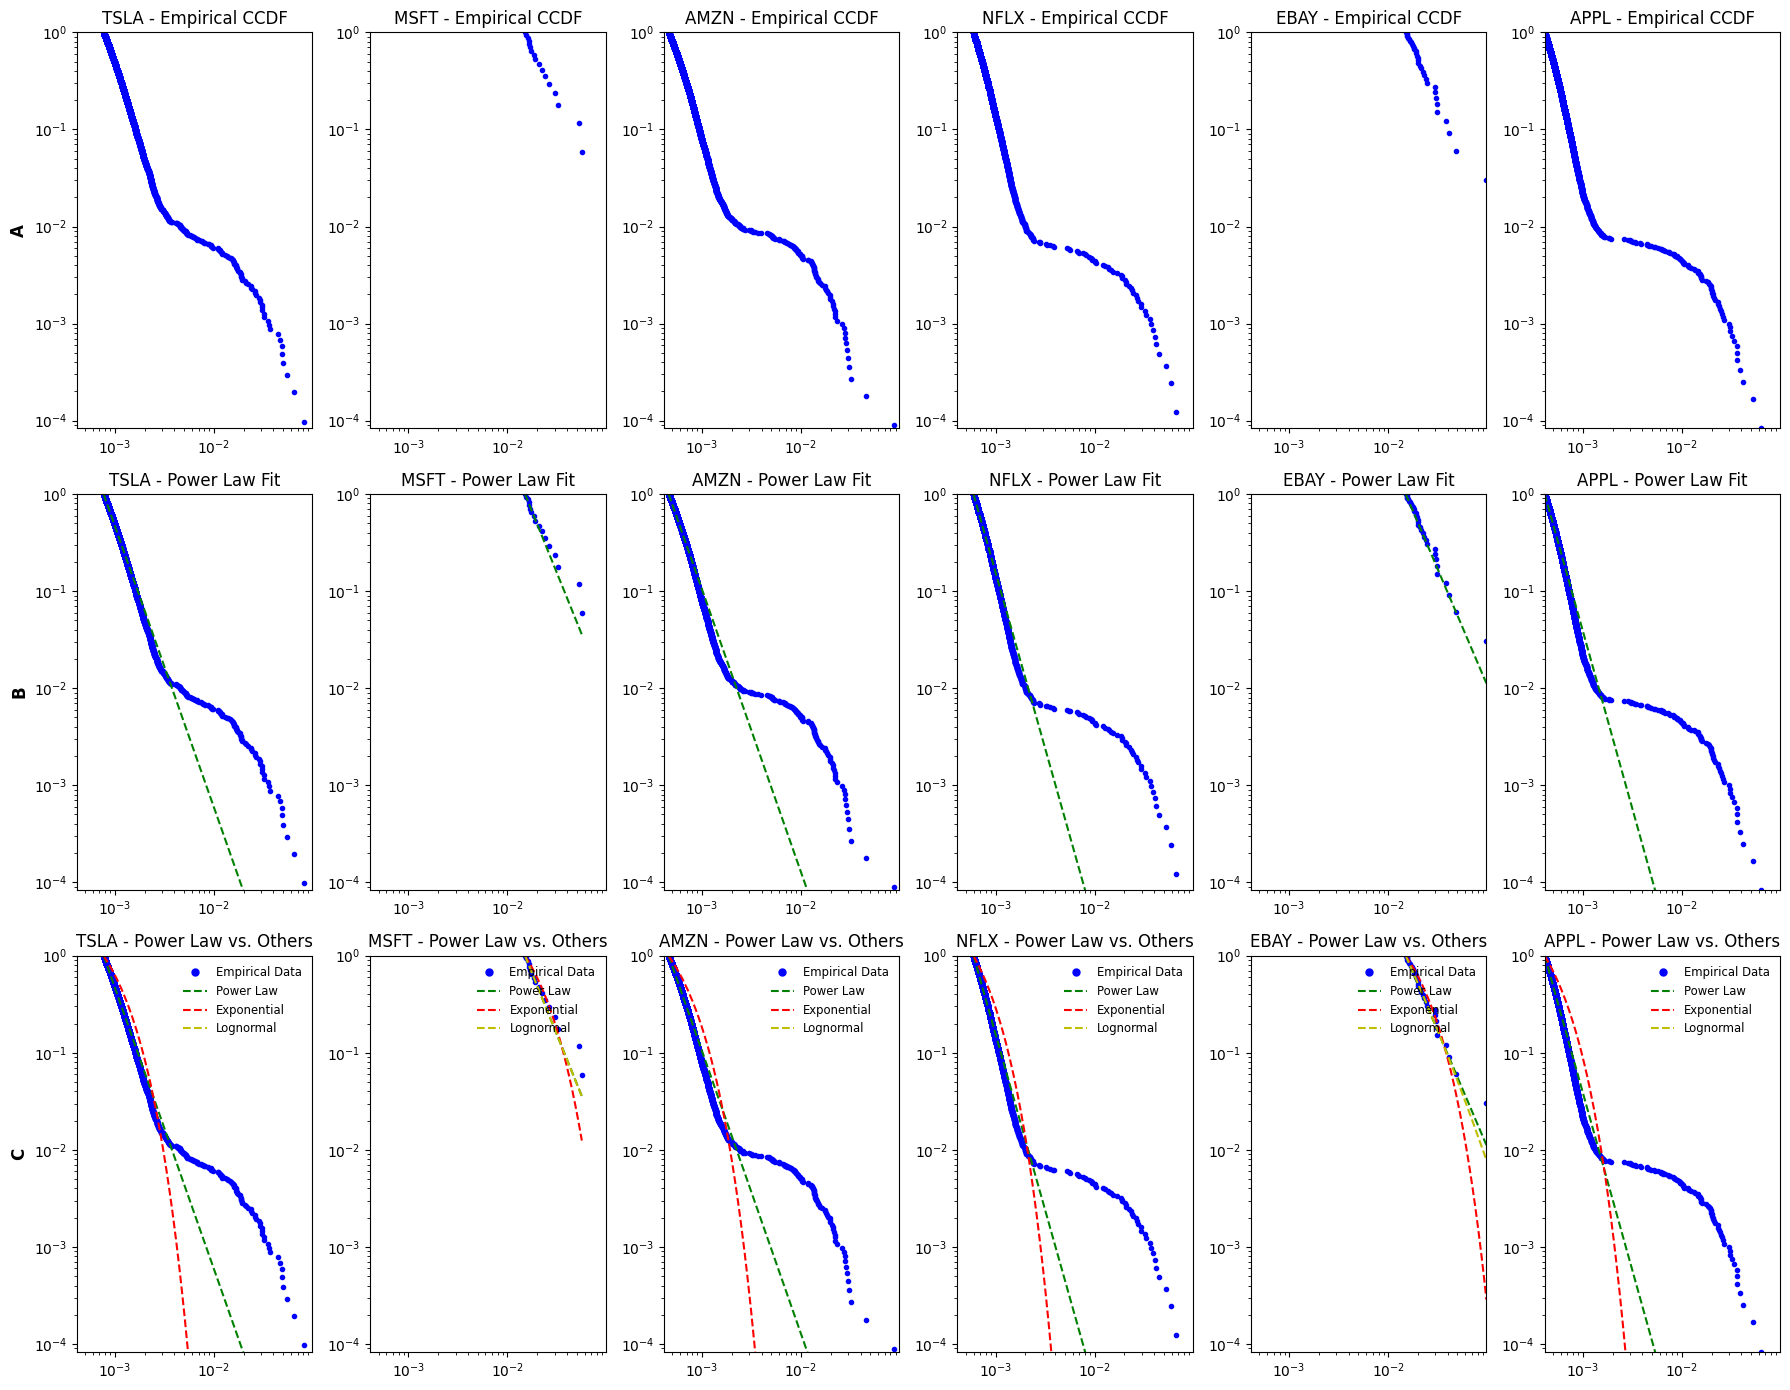

In [17]:
# Plot fitted objects
plot_fit_objects(percentage_returns_fit_objects)

#### 2.3.1. Retrieve Power law fitting results

In [18]:
# Get fitting parameters for specific distribution across all stocks
percentage_returns_power_results = get_fitting_params(percentage_returns_fit_objects, 'power_law')
print(percentage_returns_power_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.897987  0.000771     0.019991
1  MSFT    power_law  3.519558  0.015025     0.075593
2  AMZN    power_law  3.914663  0.000461     0.028308
3  NFLX    power_law  4.620739  0.000599     0.020993
4  EBAY    power_law  3.392282  0.015018     0.075980
5  APPL    power_law  4.659445  0.000413     0.028661


In [19]:
# Average Alpha exponents across stocks
min_alpha = percentage_returns_power_results['alpha'].min()
max_alpha = percentage_returns_power_results['alpha'].max()
avg_alpha = percentage_returns_power_results['alpha'].mean()
std_dev_alpha = percentage_returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.3922822530403898
Max Alpha: 4.659444798928611
Average Alpha: 4.000779066216876
std_dev_alpha: 0.5362862291924148


#### 2.3.2. Compare Alternative Distributions

In [20]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
percentage_returns_powerlaw_exponential = distribution_compare(percentage_returns_fit_objects, 'exponential')
display(percentage_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,1993.895885,0.000771,3.897987,0.019991,0.162308,8.536606,1.382221e-17
1,MSFT,exponential,106.012346,0.015025,3.519558,0.075593,0.154649,0.941686,3.463532e-01
2,AMZN,exponential,3150.412242,0.000461,3.914663,0.028308,0.181361,9.018807,1.901495e-19
3,NFLX,exponential,3071.515943,0.000599,4.620739,0.020993,0.195193,7.166299,7.705255e-13
4,EBAY,exponential,98.067612,0.015018,3.392282,0.075980,0.123586,0.798590,4.245284e-01
5,APPL,exponential,4100.738416,0.000413,4.659445,0.028661,0.226473,9.678804,3.710295e-22


## 3. Log Returns

In [21]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df, )['log_returns']
msft_log_returns = compute_returns(msft_raw_df, )['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df,)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df, )['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df,)['log_returns']
appl_log_returns = compute_returns(appl_raw_df,)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'APPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### 3.1. Stationarity Test

In [22]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -350.98
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.60
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.79
p-value: 0.00,
N: 499993, 
critical values: {'1%': -3.4303630788502493, '5%': -2.8615457806978664, '10%': -2.566773076854312}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


### 3.2. Log return density functions

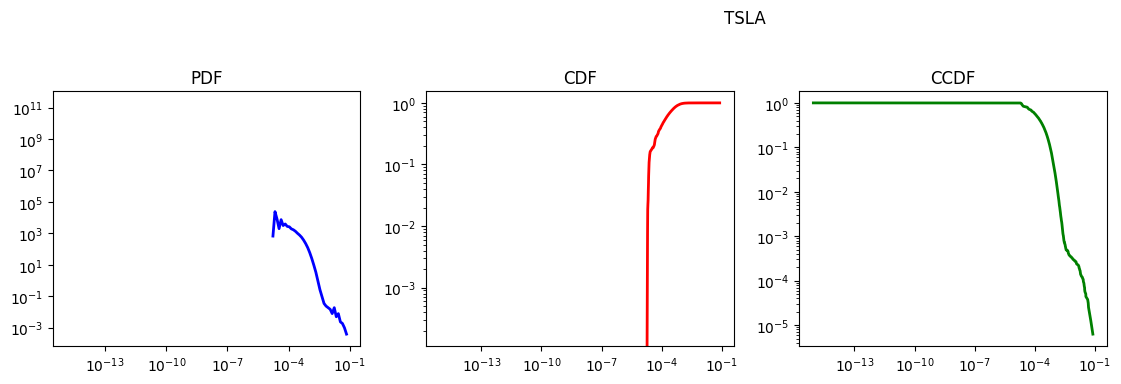

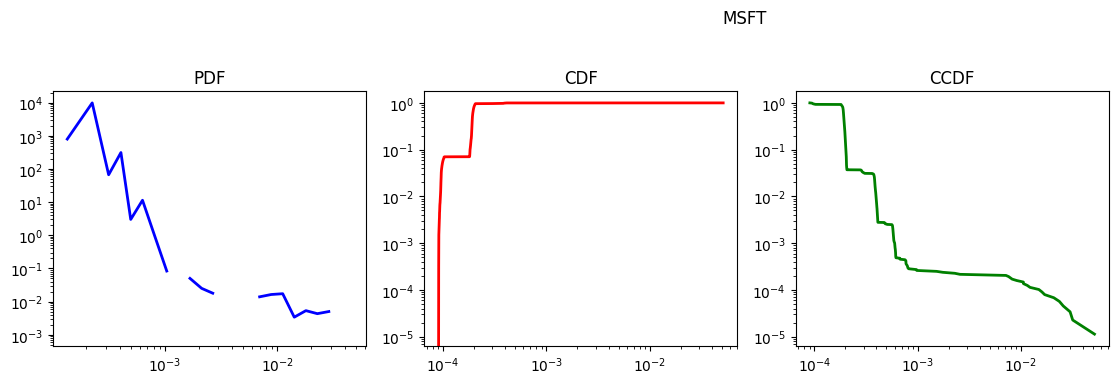

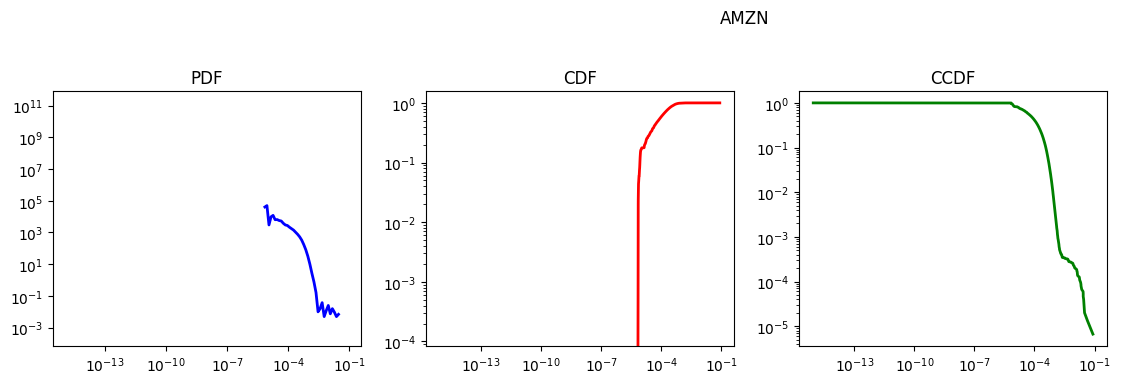

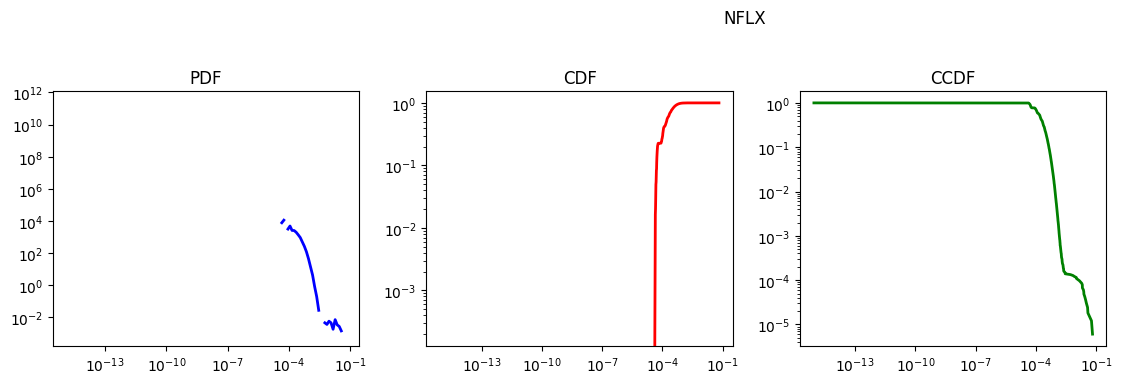

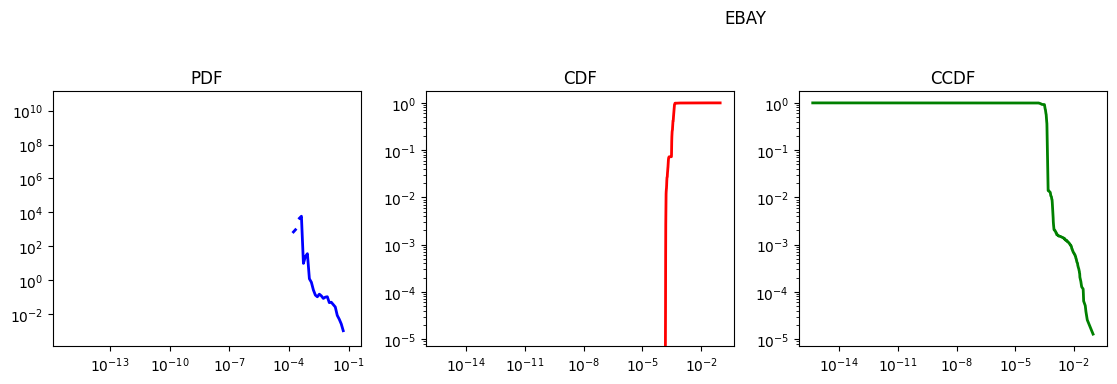

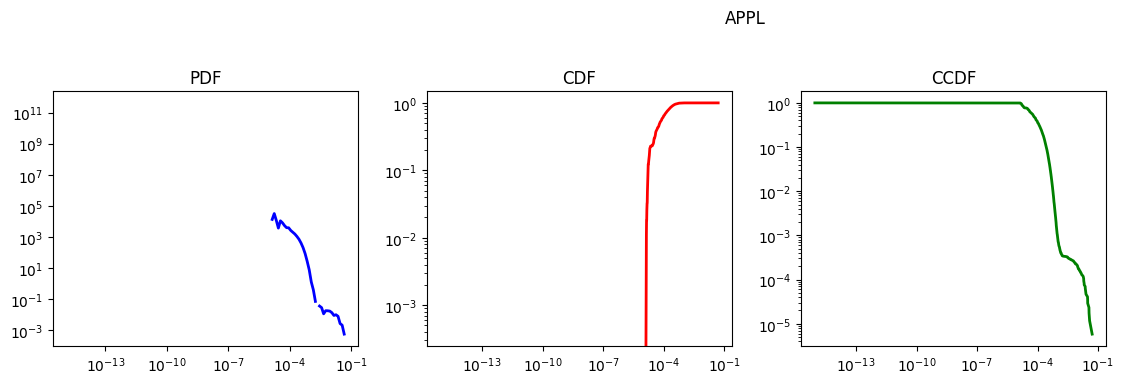

In [23]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in log_returns.items():
    plot_distributions(stock_name, data)

### 3.3. Fit power law distribution to log returns

In [24]:
# 1. Fit Powerlaw and retrieve fitted object/ results
log_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_log_returns_distributions.pkl')

if not os.path.exists(log_returns_distributions_data):
    log_returns_fit_objects = fit_powerlaw(data_dict=log_returns, filename=log_returns_distributions_data)
else:
    log_returns_fit_objects = load_fit_objects(log_returns_distributions_data)

log_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x28aaf6090>,
 'MSFT': <powerlaw.Fit at 0x2a5852810>,
 'AMZN': <powerlaw.Fit at 0x2a5bb7d50>,
 'NFLX': <powerlaw.Fit at 0x2a5bb6710>,
 'EBAY': <powerlaw.Fit at 0x2a5bb7210>,
 'APPL': <powerlaw.Fit at 0x28aaf7fd0>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution give

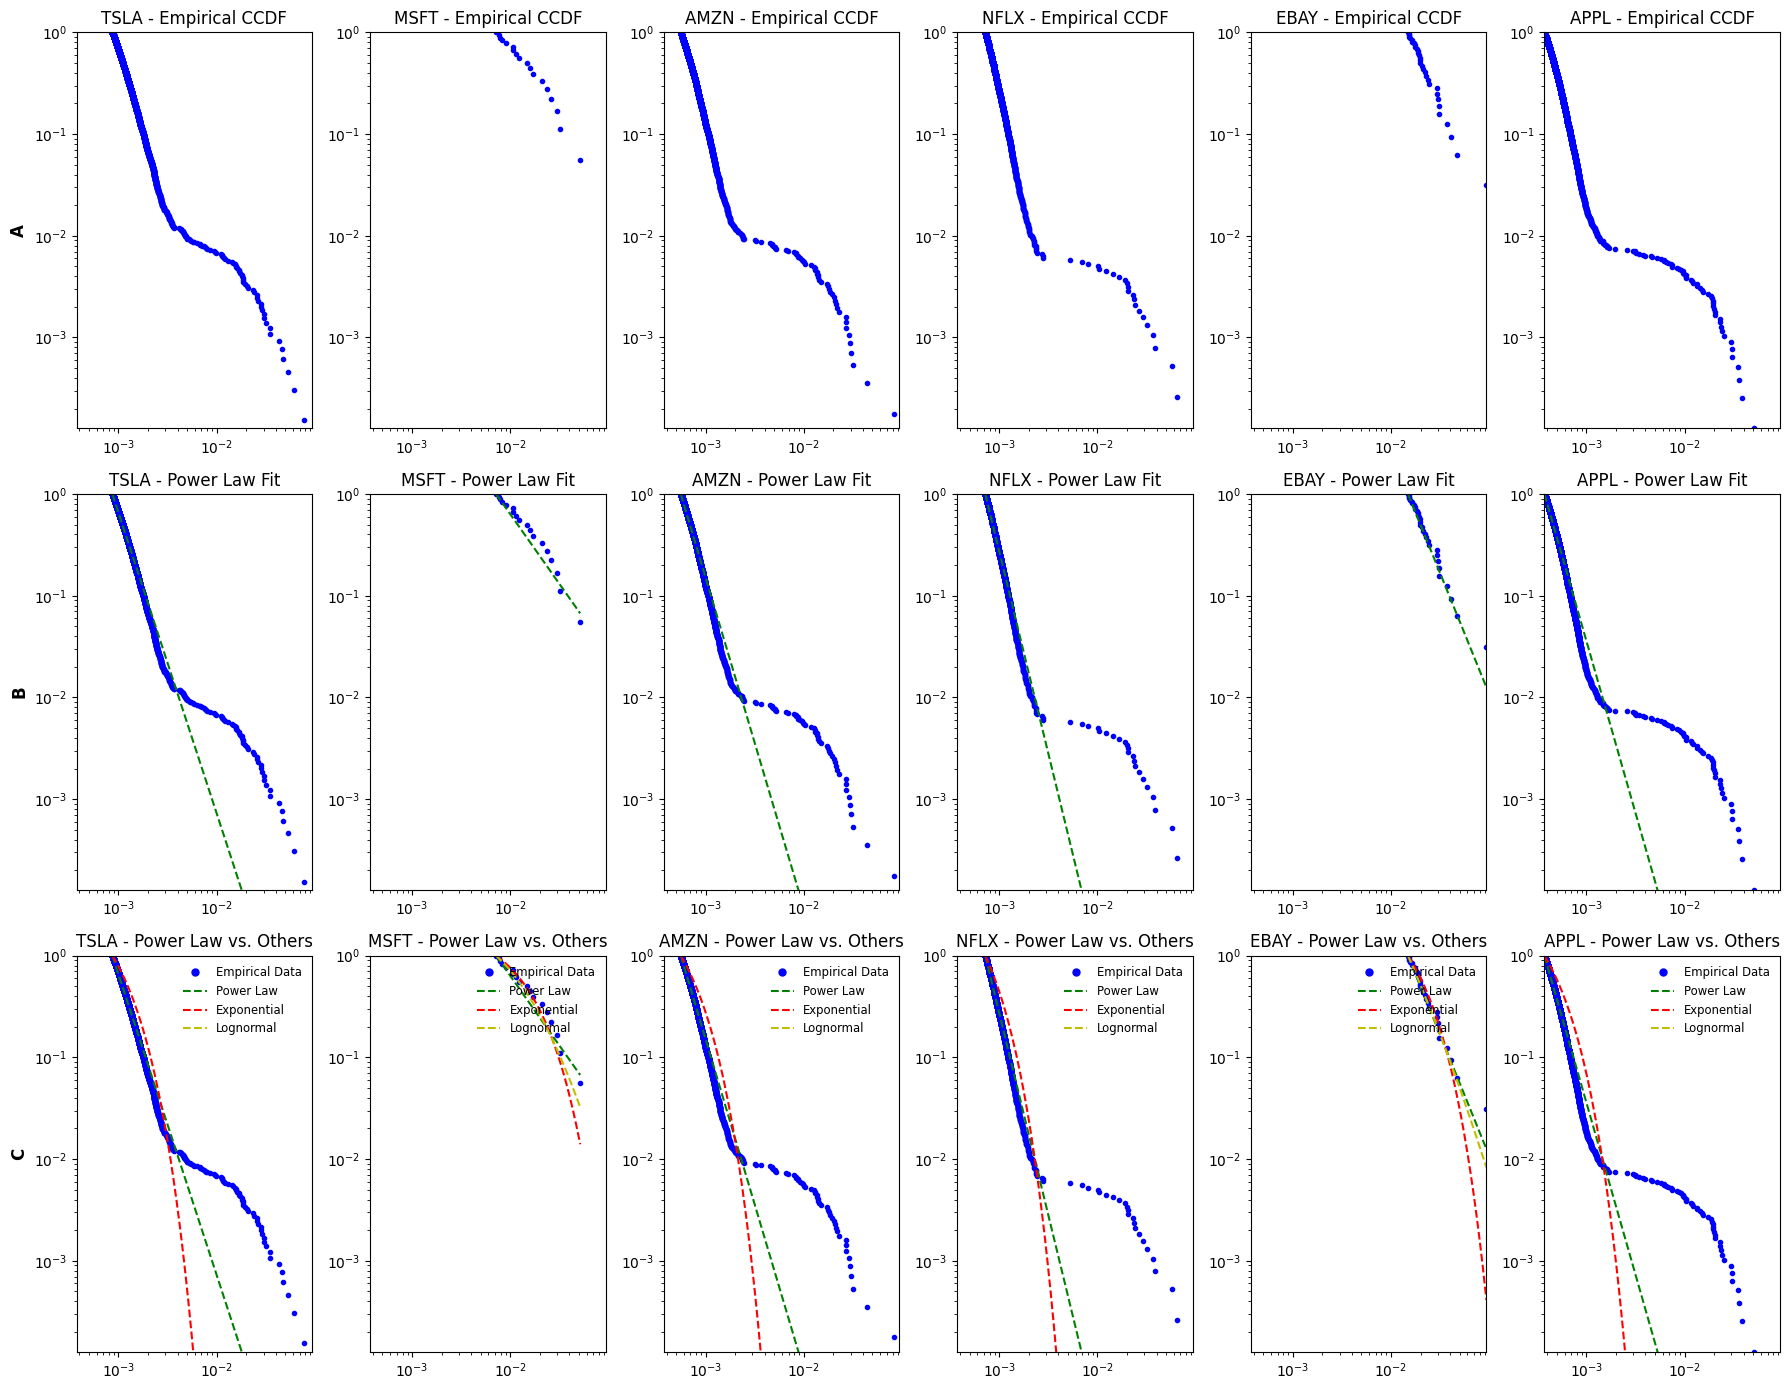

In [25]:
# Plot fitted objects
plot_fit_objects(log_returns_fit_objects)

#### 3.3.1. Retrieve Power law fitting results

In [26]:
# Get fitting parameters for specific distribution across all stocks
log_returns_power_results = get_fitting_params(log_returns_fit_objects, 'power_law')
print(log_returns_power_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.957326  0.000867     0.020998
1  MSFT    power_law  2.370098  0.007166     0.134349
2  AMZN    power_law  4.251593  0.000559     0.028143
3  NFLX    power_law  4.974865  0.000722     0.020927
4  EBAY    power_law  3.381324  0.014907     0.079617
5  APPL    power_law  4.382564  0.000374     0.031055


In [27]:
# Average Alpha exponents across stocks
min_alpha = log_returns_power_results['alpha'].min()
max_alpha = log_returns_power_results['alpha'].max()
avg_alpha = log_returns_power_results['alpha'].mean()
std_dev_alpha = log_returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.3700977886247623
Max Alpha: 4.974865429873216
Average Alpha: 3.886295173614126
std_dev_alpha: 0.9081417810948229


#### 3.3.2. Compare Alternative Distributions

In [28]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
log_returns_powerlaw_exponential = distribution_compare(log_returns_fit_objects, 'exponential')
display(log_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,1828.696600,0.000867,3.957326,0.020998,0.160032,6.951332,3.618522e-12
1,MSFT,exponential,96.295691,0.007166,2.370098,0.134349,0.071606,-0.439938,6.599821e-01
2,AMZN,exponential,2914.322402,0.000559,4.251593,0.028143,0.189314,6.347154,2.193341e-10
3,NFLX,exponential,2907.967189,0.000722,4.974865,0.020927,0.193796,4.828319,1.376901e-06
4,EBAY,exponential,99.004141,0.014907,3.381324,0.079617,0.110816,0.722650,4.698947e-01
5,APPL,exponential,4261.419370,0.000374,4.382564,0.031055,0.210727,7.604194,2.866853e-14


## 4. Return magnitudes (volatility)

In [44]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'APPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
return_magnitudes = {stock: data.head(1000000) for stock, data in return_magnitudes.items()}

### 4.1. Stationarity Test

In [37]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -49.89
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.43
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -52.60
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -50.20
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 4.2. Volatility density functions

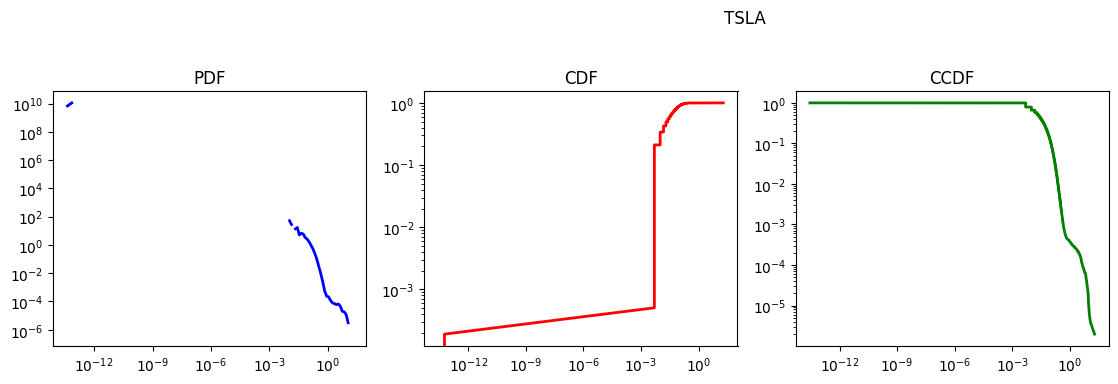

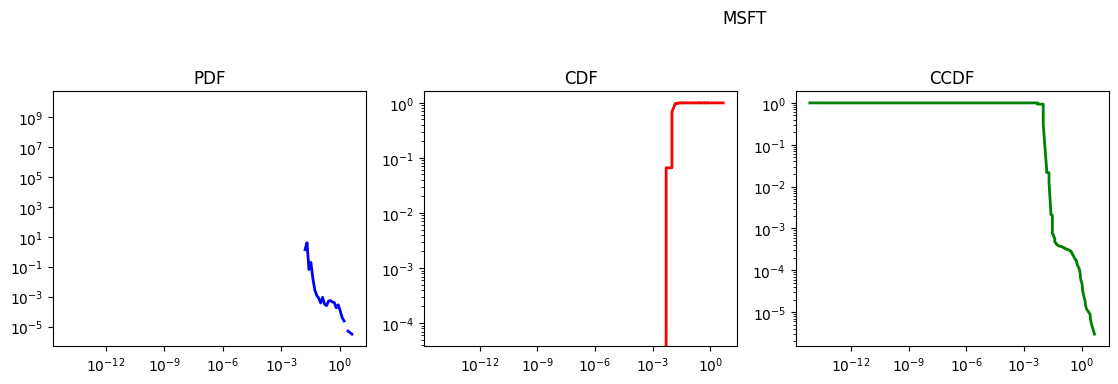

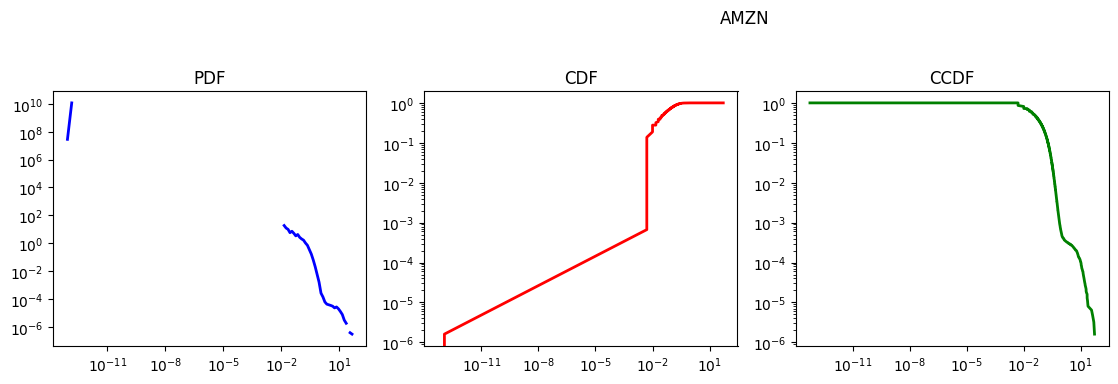

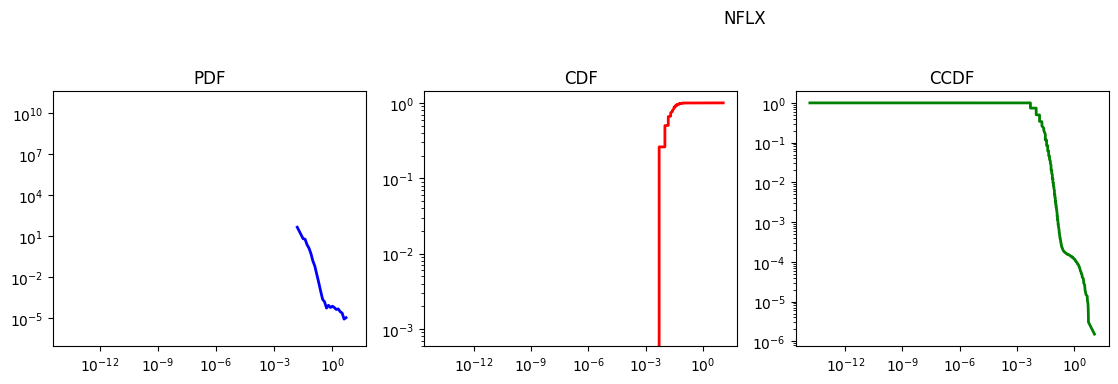

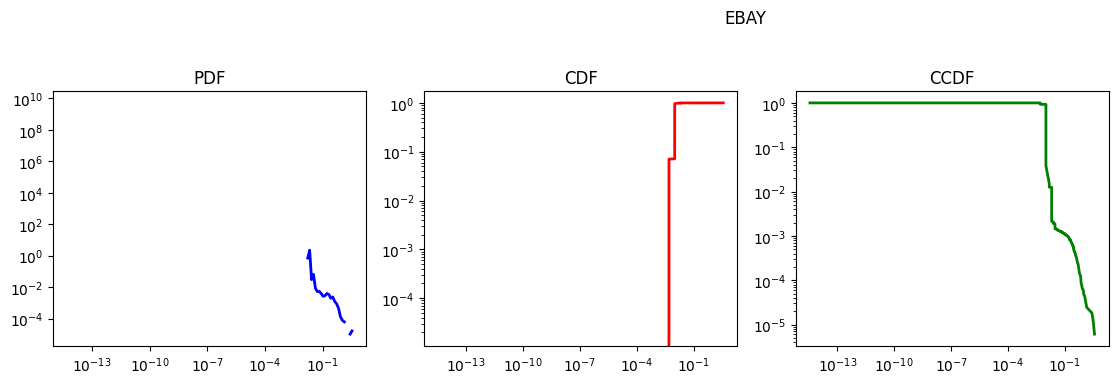

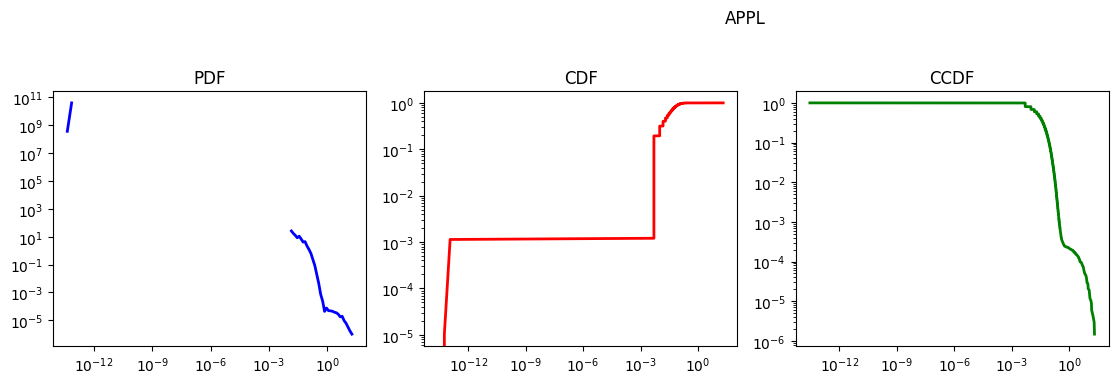

In [45]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in return_magnitudes.items():
    plot_distributions(stock_name, data)

### 4.3. Fit power law distribution to log returns

In [46]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volatility_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volatility_distributions.pkl')

if not os.path.exists(volatility_data):
    volatility_fit_objects = fit_powerlaw(data_dict=return_magnitudes, filename=volatility_data)
else:
    volatility_fit_objects = load_fit_objects(volatility_data)

volatility_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x2aab36810>,
 'MSFT': <powerlaw.Fit at 0x3238e3750>,
 'AMZN': <powerlaw.Fit at 0x2b7afbd90>,
 'NFLX': <powerlaw.Fit at 0x28a863c90>,
 'EBAY': <powerlaw.Fit at 0x29beb3510>,
 'APPL': <powerlaw.Fit at 0x2b8247ed0>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution give

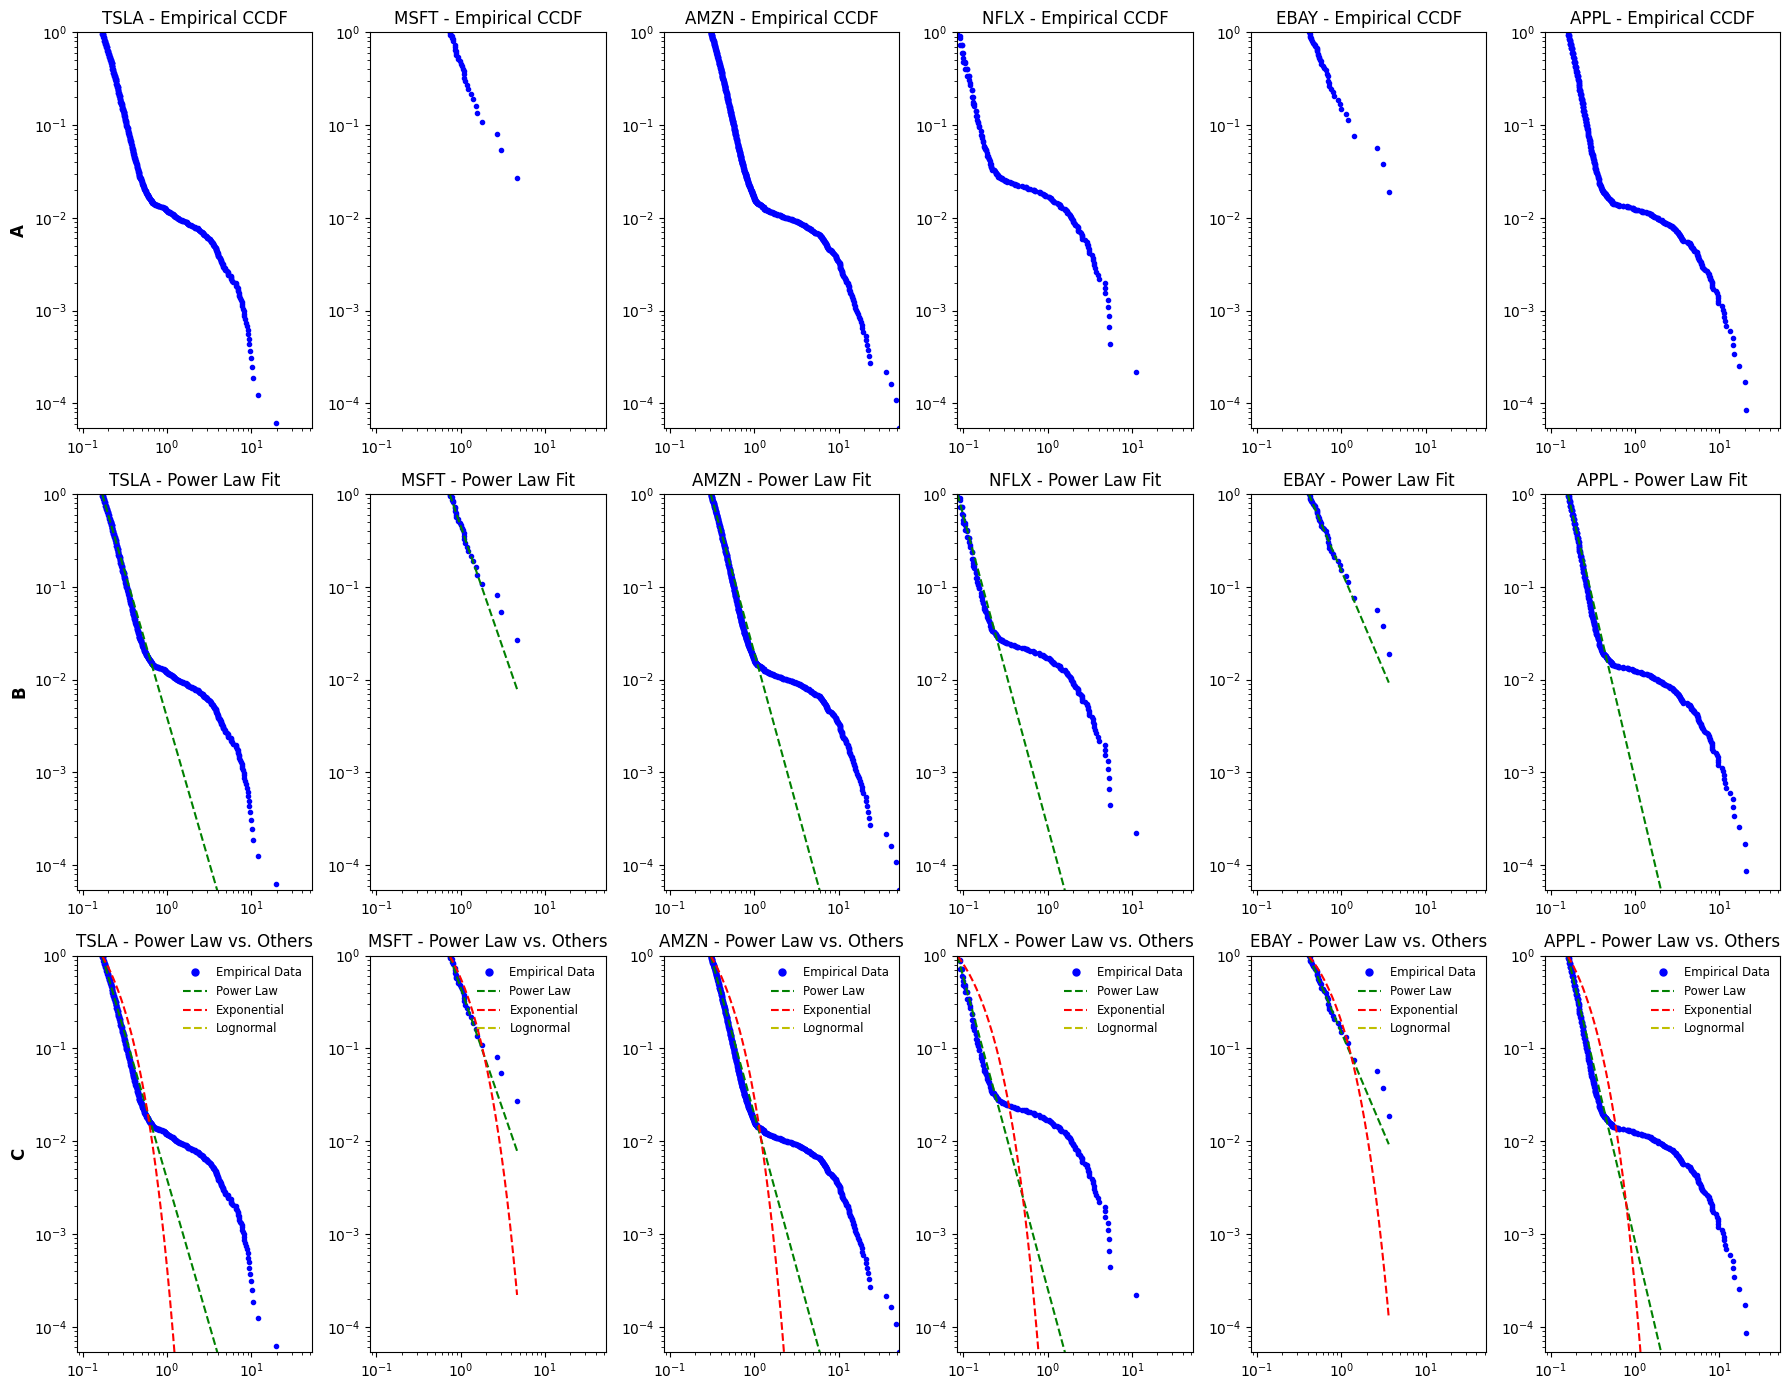

In [47]:
# Plot fitted objects
plot_fit_objects(volatility_fit_objects)

#### 4.3.1. Retrieve Power law fitting results

In [48]:
# Get fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'power_law')
print(volatility_fit_results)

  Stock Distribution     alpha   xmin  KS Distance
0  TSLA    power_law  4.130333  0.170     0.046624
1  MSFT    power_law  3.629217  0.740     0.050199
2  AMZN    power_law  4.307526  0.305     0.032511
3  NFLX    power_law  4.355844  0.085     0.099526
4  EBAY    power_law  3.139655  0.410     0.052937
5  APPL    power_law  4.862810  0.160     0.056676


In [49]:
# Average Alpha exponents across stocks
min_alpha = volatility_fit_results['alpha'].min()
max_alpha = volatility_fit_results['alpha'].max()
avg_alpha = volatility_fit_results['alpha'].mean()
std_dev_alpha = volatility_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.139655463866082
Max Alpha: 4.862810009316347
Average Alpha: 4.07089747464224
std_dev_alpha: 0.605002385930781


#### 3.3.2. Compare Alternative Distributions

In [50]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volatility_powerlaw_exponential = distribution_compare(volatility_fit_objects, 'exponential')
display(volatility_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,9.332323,0.170,4.130333,0.046624,0.204073,13.297164,2.404141e-40
1,MSFT,exponential,2.142478,0.740,3.629217,0.050199,0.157586,1.684247,9.213390e-02
2,AMZN,exponential,5.047538,0.305,4.307526,0.032511,0.235103,13.528208,1.065910e-41
3,NFLX,exponential,14.232537,0.085,4.355844,0.099526,0.365261,12.621143,1.614613e-36
4,EBAY,exponential,2.771269,0.410,3.139655,0.052937,0.171475,2.106569,3.515495e-02
5,APPL,exponential,9.799953,0.160,4.862810,0.056676,0.315167,13.511214,1.342881e-41
